In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import data

In [113]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

class Cluster:
    def __init__(self, label, columns, population=0, k=None, scale=True):
        self.label = label
        self.columns = columns
        self.scale = scale
        
        all = data.all.loc[data.all["Population Estimate, 2016"] > population]

        X = all[columns.keys()]
        self.X = X.dropna()
        self.na_count = len(X) - len(self.X)

        if self.scale:
            self.scaler = MinMaxScaler()
            self.X[self.X.columns] = self.scaler.fit_transform(self.X[self.X.columns])

        self.k = self.elbow() if k is None else k

        self.clf = KMeans(n_clusters=self.k)
        self.clf.fit(self.X)

        self.labels = pd.Series(self.clf.labels_, index=self.X.index)
        self.labels.name = "Cluster"

        # Right join drops things not in labels
        self.data = all.join(self.labels, how="right")

    def elbow(self, ks=range(2,10)):
        clfs = [KMeans(n_clusters=k).fit(self.X) for k in ks]
        inertias = [clf.inertia_ for clf in clfs]
        
        slopes = [inertias[k - min(ks)] - inertias[k + 1 - min(ks)] for k in range(min(ks), max(ks) - 1)]

        fractions =  [slopes[i + 1] / slopes[i] for i in range(0, len(slopes) - 1)]

        optimal_k = np.argmin(fractions) + min(ks) + 1

        # Plot it.
        plt.plot(ks, inertias, 'o-')

        # Highlight optimal point.
        radius = 15
        point = (optimal_k, inertias[optimal_k - min(ks)])
        plt.plot(point[0], point[1], 'o', ms=radius * 2, mec='g', mfc='none', mew=2)
        plt.annotate('Optimal K={}'.format(optimal_k), xy=point, xytext=(40, 60),
            textcoords='offset points',
            color='darkgreen',
            size='large',
            arrowprops=dict(
                arrowstyle='simple,tail_width=0.3,head_width=1,head_length=0.8',
                facecolor='g',
                shrinkA=radius ,
                shrinkB=radius * 1.3,
                edgecolor='g',
            ),
        )

        # Title and labels.
        plt.title("Optimal K for {}".format(self.label))
        plt.ylabel("Sum of Squared Error")
        plt.xlabel("Number of Clusters (K)")

        # Show it.
        plt.show()

        return optimal_k

    @property
    def clusters(self):
        cluster_centers = self.scaler.inverse_transform(self.clf.cluster_centers_) if self.scale else self.clf.cluster_centers_

        df = pd.DataFrame(cluster_centers,
            columns=list(self.columns.values())
        ).round(3)
        df.index.name = "Cluster"

        df.insert(0, "Number of Counties", self.labels.value_counts())

        df = df.join(self.data.groupby("Cluster").mean()[[
            "Population Estimate, 2016",
            "Percent of adults with a bachelor's degree or higher, 2014-18",
        ]])

        df = df.rename(columns={
            "Population Estimate, 2016": "Average Population",
            "Percent of adults with a bachelor's degree or higher, 2014-18": "Average Bachelor's Degree %",
        })

        df["Average Population"] = df["Average Population"].round()
        df["Average Bachelor's Degree %"] = df["Average Bachelor's Degree %"].round(1)

        return df.sort_values(by=["Number of Counties"])

    def counties_in_cluster(self, cluster):
        df = self.data.loc[self.data["Cluster"] == cluster]
        df = df[["State", "County", "Population Estimate, 2016",]]
        return df.rename(columns={ "Population Estimate, 2016": "Population" })

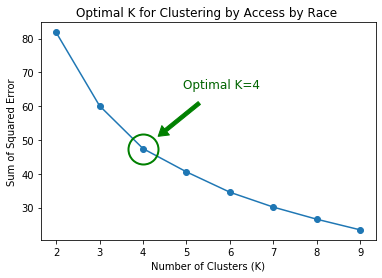

,Number of Counties,"White, low access to stores (%)","Black, low access to stores (%)","Hispanic, low access to stores (%)","Asian, low access to stores (%)","American Indian or Alaska Native, low access to stores (%)","Hawaiian or Pacific Islander, low access to stores (%)",Average Population,Average Bachelor's Degree %
Cluster,,,,,,,,,
2,131,85.448,0.711,10.235,0.300,1.157,0.038,2711.0,20.7
3,183,13.391,15.066,1.215,0.243,0.157,0.014,88424.0,18.4
1,1020,27.620,1.163,3.105,0.378,1.235,0.026,102467.0,23.6
0,1787,9.738,1.027,0.882,0.173,0.524,0.014,112824.0,20.8


In [114]:
Cluster("Clustering by Access by Race ", {
    "PCT_LACCESS_WHITE15": "White, low access to stores (%)",
    "PCT_LACCESS_BLACK15": "Black, low access to stores (%)",
    "PCT_LACCESS_HISP15": "Hispanic, low access to stores (%)",
    "PCT_LACCESS_NHASIAN15": "Asian, low access to stores (%)",
    "PCT_LACCESS_NHNA15": "American Indian or Alaska Native, low access to stores (%)",
    "PCT_LACCESS_NHPI15": "Hawaiian or Pacific Islander, low access to stores (%)",
}).clusters

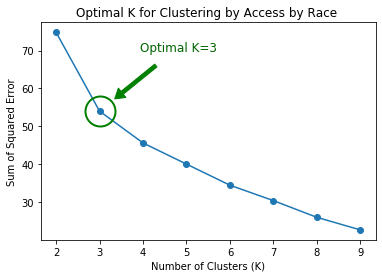

,Number of Counties,"White, low access to stores (%)","Black, low access to stores (%)","Hispanic, low access to stores (%)","Asian, low access to stores (%)","American Indian or Alaska Native, low access to stores (%)","Hawaiian or Pacific Islander, low access to stores (%)",Average Population,Average Bachelor's Degree %
Cluster,,,,,,,,,
1,207,13.948,13.722,1.347,0.273,0.175,0.018,93008.0,19.0
2,806,30.265,1.112,3.832,0.416,0.946,0.036,107088.0,23.8
0,1868,10.484,1.012,0.949,0.170,0.511,0.010,115930.0,21.0


In [116]:
Cluster("Clustering by Access by Race ", {
    "PCT_LACCESS_WHITE15": "White, low access to stores (%)",
    "PCT_LACCESS_BLACK15": "Black, low access to stores (%)",
    "PCT_LACCESS_HISP15": "Hispanic, low access to stores (%)",
    "PCT_LACCESS_NHASIAN15": "Asian, low access to stores (%)",
    "PCT_LACCESS_NHNA15": "American Indian or Alaska Native, low access to stores (%)",
    "PCT_LACCESS_NHPI15": "Hawaiian or Pacific Islander, low access to stores (%)",
}, population=4000).clusters

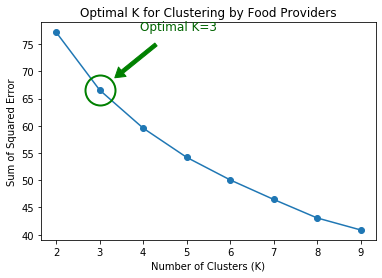

,Number of Counties,"Grocery stores per 1,000 People","Supercenters per 1,000 People","Convenience stores per 1,000 People","Specialized food stores per 1,000 People","Fast-food restaurants per 1,000 People","Full-service restaurants per 1,000 People","Farmers' markets per 1,000 People",Average Population,Average Bachelor's Degree %
Cluster,,,,,,,,,,
2,371,0.644,0.000,0.859,0.076,0.514,1.423,0.183,23645.0,22.4
0,668,0.194,0.052,0.625,0.051,0.661,0.765,0.054,38967.0,19.4
1,2101,0.201,0.011,0.540,0.048,0.561,0.673,0.038,137222.0,22.1


In [118]:
choice = Cluster("Clustering by Food Providers", {
    "GROCPTH14": "Grocery stores per 1,000 People",
    "SUPERCPTH14": "Supercenters per 1,000 People",
    "CONVSPTH14": "Convenience stores per 1,000 People",
    "SPECSPTH14": "Specialized food stores per 1,000 People",
    "FFRPTH14": "Fast-food restaurants per 1,000 People",
    "FSRPTH14": "Full-service restaurants per 1,000 People",
    "FMRKTPTH16": "Farmers' markets per 1,000 People",
})
choice.clusters

In [27]:
choice.counties_in_cluster(4)

,State,County,Population
8053,Colorado,Hinsdale,788
8079,Colorado,Mineral,732
8111,Colorado,San Juan,694
38007,North Dakota,Billings,934


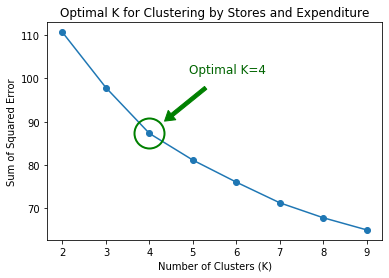

,Number of Counties,"Grocery stores per 1,000 People","Supercenters per 1,000 People","Convenience stores per 1,000 People","Fast-food restaurants per 1,000 People","Full-service restaurants per 1,000 People","Farmers' markets per 1,000 People","Expenditures per capita, fast food","Expenditures per capita, restaurants",Average Population,Average Bachelor's Degree %
Cluster,,,,,,,,,,,
3,231,0.772,-0.000,0.815,0.467,1.419,0.228,567.646,653.793,5045.0,22.2
2,442,0.199,0.059,0.627,0.681,0.774,0.058,613.796,613.886,31274.0,19.0
0,863,0.237,0.014,0.518,0.550,0.872,0.061,501.126,684.431,141663.0,24.4
1,1604,0.199,0.012,0.597,0.578,0.642,0.033,653.424,644.676,115874.0,20.7


In [119]:
stores_expenditure = Cluster("Clustering by Stores and Expenditure", {
    "GROCPTH14": "Grocery stores per 1,000 People",
    "SUPERCPTH14": "Supercenters per 1,000 People",
    "CONVSPTH14": "Convenience stores per 1,000 People",
    # "SPECSPTH14": "Specialized food stores per 1,000 People",
    "FFRPTH14": "Fast-food restaurants per 1,000 People",
    "FSRPTH14": "Full-service restaurants per 1,000 People",
    "FMRKTPTH16": "Farmers' markets per 1,000 People",
    # "MILK_PRICE10": "Price of low-fat milk/national average",
    # "SODA_PRICE10": "Price of sodas/national average",
    # "FOODINSEC_13_15": "Statewide Household Food Insecurity",
    "PC_FFRSALES12": "Expenditures per capita, fast food",
    "PC_FSRSALES12": "Expenditures per capita, restaurants",
})
stores_expenditure.clusters

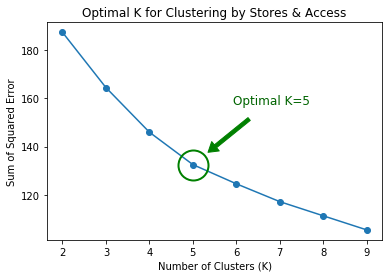

,Number of Counties,"Grocery stores per 1,000 People","Supercenters per 1,000 People","Convenience stores per 1,000 People","Fast-food restaurants per 1,000 People","Full-service restaurants per 1,000 People","Farmers' markets per 1,000 People","Population, low access to store (%)","Low income & low access to store (%), 2015",Average Population,Average Bachelor's Degree %
Cluster,,,,,,,,,,,
3,117,0.376,0.007,0.721,0.358,0.699,0.078,59.757,26.586,12706.0,17.0
1,214,0.420,0.005,0.704,0.666,1.569,0.211,19.373,6.661,25381.0,25.3
4,368,0.201,0.061,0.660,0.649,0.774,0.062,17.407,7.122,26884.0,18.4
0,1028,0.178,0.019,0.498,0.637,0.687,0.029,28.001,10.035,167290.0,24.7
2,1154,0.215,0.011,0.579,0.533,0.634,0.041,10.085,3.715,115543.0,19.9


In [120]:
stores_access = Cluster("Clustering by Stores & Access", {
    "GROCPTH14": "Grocery stores per 1,000 People",
    "SUPERCPTH14": "Supercenters per 1,000 People",
    "CONVSPTH14": "Convenience stores per 1,000 People",
    # "SPECSPTH14": "Specialized food stores per 1,000 People",
    "FFRPTH14": "Fast-food restaurants per 1,000 People",
    "FSRPTH14": "Full-service restaurants per 1,000 People",
    "FMRKTPTH16": "Farmers' markets per 1,000 People",
    # "MILK_PRICE10": "Price of low-fat milk/national average",
    # "SODA_PRICE10": "Price of sodas/national average",
    # "FOODINSEC_13_15": "Statewide Household Food Insecurity",
    # "PC_FFRSALES12": "Expenditures per capita, fast food",
    # "PC_FSRSALES12": "Expenditures per capita, restaurants",
    "PCT_LACCESS_POP15": "Population, low access to store (%)",
    "PCT_LACCESS_LOWI15": "Low income & low access to store (%), 2015",
}, population=4000)
stores_access.clusters

In [70]:
len(data.all.loc[data.all["Population Estimate, 2016"] < 4000])

240

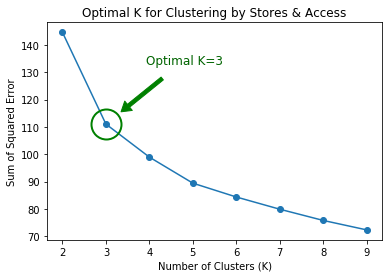

,Number of Counties,"Grocery stores per 1,000 People","Supercenters per 1,000 People","Convenience stores per 1,000 People","Fast-food restaurants per 1,000 People","Full-service restaurants per 1,000 People","Farmers' markets per 1,000 People","Population, low access to store (%)","Low income & low access to store (%), 2015",Average Population,Average Bachelor's Degree %
Cluster,,,,,,,,,,,
2,160,0.623,0.002,0.831,0.353,1.147,0.119,89.216,35.179,4064.0,19.8
0,1180,0.235,0.021,0.577,0.610,0.775,0.053,31.245,11.703,106671.0,22.6
1,1781,0.229,0.018,0.588,0.574,0.752,0.056,11.647,4.181,110133.0,21.1


In [121]:
stores_access_all = Cluster("Clustering by Stores & Access", {
    "GROCPTH14": "Grocery stores per 1,000 People",
    "SUPERCPTH14": "Supercenters per 1,000 People",
    "CONVSPTH14": "Convenience stores per 1,000 People",
    # "SPECSPTH14": "Specialized food stores per 1,000 People",
    "FFRPTH14": "Fast-food restaurants per 1,000 People",
    "FSRPTH14": "Full-service restaurants per 1,000 People",
    "FMRKTPTH16": "Farmers' markets per 1,000 People",
    # "MILK_PRICE10": "Price of low-fat milk/national average",
    # "SODA_PRICE10": "Price of sodas/national average",
    # "FOODINSEC_13_15": "Statewide Household Food Insecurity",
    # "PC_FFRSALES12": "Expenditures per capita, fast food",
    # "PC_FSRSALES12": "Expenditures per capita, restaurants",
    "PCT_LACCESS_POP15": "Population, low access to store (%)",
    "PCT_LACCESS_LOWI15": "Low income & low access to store (%), 2015",
}, population=0)
stores_access_all.clusters

In [126]:
Cluster("Low Income, Low Access", {
    "PCT_LACCESS_LOWI15": "Low income & low access to stores (%)",
}, k=2).clusters

,Number of Counties,Low income & low access to stores (%),Average Population,Average Bachelor's Degree %
Cluster,,,,
1,260,30.476,17035.0,18.5
0,2861,6.638,111234.0,21.9


In [127]:
Cluster("Low Access", {
    "PCT_LACCESS_POP15": "Low access to stores (%)",
}, k=2).clusters

,Number of Counties,Low access to stores (%),Average Population,Average Bachelor's Degree %
Cluster,,,,
1,198,82.611,5912.0,19.8
0,2923,19.025,109989.0,21.7


In [128]:
Cluster("Low Access", {
    "PCT_LACCESS_POP15": "Low access to stores (%)",
    "PCT_LACCESS_LOWI15": "Low income & low access to stores (%)",
}, k=2).clusters

,Number of Counties,Low access to stores (%),Low income & low access to stores (%),Average Population,Average Bachelor's Degree %
Cluster,,,,,
1,203,81.458,32.701,6707.0,19.1
0,2918,18.996,6.948,110112.0,21.7
